<a href="https://colab.research.google.com/github/vishkaush/classroom-analytics/blob/main/classroom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
from random import shuffle
import glob
import pickle

from google.colab import drive
drive.mount('/content/drive')

dir_path = '/content/drive/MyDrive/classroom_analytics/experiment_2/labeled/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# GPU enabled opencv

In [2]:
# !cp "/content/drive/MyDrive/cv2_gpu/cv2.cpython-37m-x86_64-linux-gnu.so" .
import cv2
cv2.__version__

'4.5.3-pre'

# Helper Functions

In [2]:
def extract_boxes_confidences_classids_yolov2(output, confidence, width, height):
    # yolov2 output is vectors of length 4 (x, y, w, h) + 1 (box confidence) + num_classes (probabilities)
    boxes = []
    confidences = []
    classIDs = []

    for detection in output:            
        scores = detection[5:]
        classID = np.argmax(scores)
        conf = scores[classID]
        
        # Consider only the predictions that are above the confidence threshold
        if conf > confidence:
            # Scale the bounding box back to the size of the image
            box = detection[0:4] * np.array([width, height, width, height])
            centerX, centerY, w, h = box.astype('int')

            # Use the center coordinates, width and height to get the coordinates of the top left corner
            x = int(centerX - (w / 2))
            y = int(centerY - (h / 2))

            boxes.append([x, y, int(w), int(h)])
            confidences.append(float(conf))
            classIDs.append(classID)

    return boxes, confidences, classIDs
  
def extract_boxes_confidences_classids_yolov3(outputs, confidence, width, height):
    boxes = []
    confidences = []
    classIDs = []
    for output in outputs:
      for detection in output:            
          scores = detection[5:]
          classID = np.argmax(scores)
          conf = scores[classID]
          
          # Consider only the predictions that are above the confidence threshold
          if conf > confidence:
              # Scale the bounding box back to the size of the image
              box = detection[0:4] * np.array([width, height, width, height])
              centerX, centerY, w, h = box.astype('int')

              # Use the center coordinates, width and height to get the coordinates of the top left corner
              x = int(centerX - (w / 2))
              y = int(centerY - (h / 2))

              boxes.append([x, y, int(w), int(h)])
              confidences.append(float(conf))
              classIDs.append(classID)

    return boxes, confidences, classIDs

def annotate_all(image, boxes, confidences, classIDs, idxs, colors, classes):
  # colors should be in BGR
  if len(idxs) > 0:
    annotated_image = image.copy()
    for i in idxs.flatten():
      # extract bounding box coordinates
      x, y = boxes[i][0], boxes[i][1]
      w, h = boxes[i][2], boxes[i][3]

      # draw the bounding box and label on the image
      color = [int(c) for c in colors[classIDs[i]]]
      cv2.rectangle(annotated_image, (x, y), (x + w, y + h), color, 2)
      text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
      cv2.putText(annotated_image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  return annotated_image

def annotate_one(image, boxes, confidences, classIDs, idxs, classes, single_class):
  # colors should be in BGR
  if len(idxs) > 0:
    annotated_image = image.copy()
    for i in idxs.flatten():
      # extract bounding box coordinates
      x, y = boxes[i][0], boxes[i][1]
      w, h = boxes[i][2], boxes[i][3]
      obj_class = str(classes[classIDs[i]])
      if obj_class == single_class:
        # draw the bounding box and label on the image
        cv2.rectangle(annotated_image, (x, y), (x + w, y + h), [255, 255, 255], 2)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv2.putText(annotated_image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, [255,255,255], 2)
  return annotated_image

def draw_grid(image, gridBoxes):
  annotated_image = image.copy()
  for i in range(len(gridBoxes)):
    x, y = gridBoxes[i][0], gridBoxes[i][1]
    w, h = gridBoxes[i][2]-gridBoxes[i][0], gridBoxes[i][3]-gridBoxes[i][1]
    cv2.rectangle(annotated_image, (x, y), (x + w, y + h), [255, 255, 255], 2)
  return annotated_image

def computeGrid(width, height):
  # each box is represented by top left and bottom right coordinates
  gridBoxes = []
  gridWidth = width//10
  gridHeight = height//10
  xMax = width - gridWidth
  currentBox = [0, 0, gridWidth, gridHeight]
  gridBoxes.append(currentBox.copy())
  for i in range(99):
    currentBox[0] = currentBox[0] + gridWidth
    currentBox[2] = currentBox[2] + gridWidth
    if currentBox[0] == xMax:
      gridBoxes.append(currentBox.copy())
      currentBox[0] = -(gridWidth)
      currentBox[1] = currentBox[1] + gridHeight
      currentBox[2] = 0
      currentBox[3] = currentBox[3] + gridHeight
    else:
      gridBoxes.append(currentBox.copy())
  return gridBoxes

def calculateIOUs(width, height, gridBoxes, boxes):
  gridWidth = width//10
  gridHeight = height//10
  #print("gridWidth: ", gridWidth, "gridHeight: ", gridHeight)
  iouValues = []
  for i in range(len(gridBoxes)):
    iou = 0.0
    xGridBoxTopLeft = gridBoxes[i][0]
    yGridBoxTopLeft = gridBoxes[i][1]
    xGridBoxBottomRight = gridBoxes[i][2]
    yGridBoxBottomRight = gridBoxes[i][3]
    assert(xGridBoxTopLeft>=0 and yGridBoxTopLeft>=0 and xGridBoxBottomRight>=0 and yGridBoxBottomRight>=0)
    gridBoxArea = (xGridBoxBottomRight-xGridBoxTopLeft)*(yGridBoxBottomRight-yGridBoxTopLeft)
    #print(f"Grid box {i}: {xGridBoxTopLeft}, {yGridBoxTopLeft}, {xGridBoxBottomRight}, {yGridBoxBottomRight} and area = {gridBoxArea}")
    for j in range(len(boxes)):
      xYoloBoxTopLeft = boxes[j][0]
      yYoloBoxTopLeft = boxes[j][1]
      xYoloBoxBottomRight = xYoloBoxTopLeft + boxes[j][2]
      yYoloBoxBottomRight = yYoloBoxTopLeft + boxes[j][3]
      yoloBoxArea = (xYoloBoxBottomRight-xYoloBoxTopLeft)*(yYoloBoxBottomRight-yYoloBoxTopLeft)
      #print(f"Yolo box {j}: {xYoloBoxTopLeft}, {yYoloBoxTopLeft}, {xYoloBoxBottomRight}, {yYoloBoxBottomRight} and area = {yoloBoxArea}")
      xIntersectTopLeft = max(xGridBoxTopLeft,xYoloBoxTopLeft)
      yIntersectTopLeft = max(yGridBoxTopLeft,yYoloBoxTopLeft)
      xIntersectBottomRight = min(xGridBoxBottomRight,xYoloBoxBottomRight)
      yIntersectBottomRight = min(yGridBoxBottomRight,yYoloBoxBottomRight)
      # intersect area
      intersectArea=max(xIntersectBottomRight-xIntersectTopLeft,0)*max(yIntersectBottomRight-yIntersectTopLeft,0)
      iou += intersectArea/(gridBoxArea+yoloBoxArea-intersectArea)
    iouValues.append(round(iou, 3))
  return np.array(iouValues)

# Test Helper Functions on a single image

In [9]:
# tiny-yolo-v2 for uniform detection
uniform_weightsPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'tiny-yolo-uniform_40000.weights')
uniform_configPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'tiny-yolo-uniform.cfg')
uniform_labelsPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'uniform.names')
uniform_labels = open(uniform_labelsPath).read().strip().split('\n')
uniform_colors = np.array([[255, 255, 255], [0, 0, 255], [255, 0, 0]])    # (BGR) girl = white, no = red, boy = blue

#tiny-yolo-v3 for person detection
person_weightsPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'yolov3-tiny.weights')
person_configPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'yolov3-tiny.cfg')
person_labelsPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'coco.names')
person_labels = open(person_labelsPath).read().strip().split('\n')

confidenceThreshold = 0.35
uniform_nmsThreshold = 1   # 1 implies no suppression, 0 implies aggressive suppression
person_nmsThreshold = 1

uniform_net = cv2.dnn.readNetFromDarknet(uniform_configPath, uniform_weightsPath)
person_net = cv2.dnn.readNetFromDarknet(person_configPath, person_weightsPath)
# uniform_net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# uniform_net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
# person_net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# person_net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

uniform_layer_names = uniform_net.getLayerNames()
print("Uniform Net Layer names: ", uniform_layer_names)
print("Unconnected Out Uniform Net Layer names: ", uniform_net.getUnconnectedOutLayersNames())

person_layer_names = person_net.getLayerNames()
print("Person Net Layer names: ", person_layer_names)
print("Unconnected Out Person Net Layer names: ", person_net.getUnconnectedOutLayersNames())

Uniform Net Layer names:  ['conv_0', 'bn_0', 'relu_0', 'pool_1', 'conv_2', 'bn_2', 'relu_2', 'pool_3', 'conv_4', 'bn_4', 'relu_4', 'pool_5', 'conv_6', 'bn_6', 'relu_6', 'pool_7', 'conv_8', 'bn_8', 'relu_8', 'pool_9', 'conv_10', 'bn_10', 'relu_10', 'pool_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'permute_15', 'detection_out']
Unconnected Out Uniform Net Layer names:  ['detection_out']
Person Net Layer names:  ['conv_0', 'bn_0', 'relu_0', 'pool_1', 'conv_2', 'bn_2', 'relu_2', 'pool_3', 'conv_4', 'bn_4', 'relu_4', 'pool_5', 'conv_6', 'bn_6', 'relu_6', 'pool_7', 'conv_8', 'bn_8', 'relu_8', 'pool_9', 'conv_10', 'bn_10', 'relu_10', 'pool_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'conv_15', 'permute_16', 'yolo_16', 'identity_17', 'conv_18', 'bn_18', 'relu_18', 'upsample_19', 'concat_20', 'conv_21', 'bn_21', 'relu_21', 'conv_22', 'permute_23', 'yolo_23']
Unconnected Out Person Net Layer names:  ['yolo_1

Shape of this image is  (720, 1280, 3)
Type of this image is  uint8


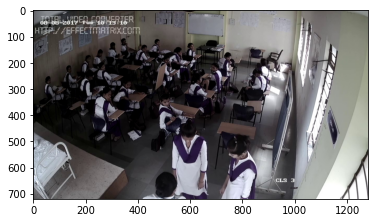

In [10]:
img = cv2.imread(os.path.join('/content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdalab-080817-1013/started', 'apollo-gdalab-080817-1013_125.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print("Shape of this image is ", img.shape)
print("Type of this image is ", img.dtype)

output's shape:  (845, 8)
Number of detections before NMS:  21
Number of detections after NMS:  21


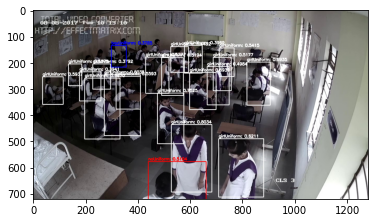

In [11]:
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 load images as BGR, convert it to RGB
height, width = img.shape[:2] 
blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
# r = blob[0, 0, :, :]
# plt.imshow()
uniform_net.setInput(blob)
#print("After setInput: ", net.dump())
output = uniform_net.forward("detection_out")
print("output's shape: ", output.shape)
#print("After forward: ", net.dump())
boxes, confidences, classIDs = extract_boxes_confidences_classids_yolov2(output, confidenceThreshold, width, height)
print("Number of detections before NMS: ", len(boxes))
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidenceThreshold, uniform_nmsThreshold)
#print("Shape of idxs: ", idxs.shape)
print("Number of detections after NMS: ", len(idxs))
annotated_img = annotate_all(img, boxes, confidences, classIDs, idxs, uniform_colors, uniform_labels)
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
#plt.imshow(annotated_img)

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.800e-02 0.000e+00
 6.100e-02 4.000e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 6.300e-02 4.480e-01 2.000e-01 9.450e-01 5.540e-01 6.400e-02 8.000e-03
 0.000e+00 0.000e+00 1.810e-01 8.630e-01 5.540e-01 5.300e-01 5.880e-01
 1.085e+00 3.140e-01 3.100e-02 0.000e+00 0.000e+00 4.710e-01 4.740e-01
 7.440e-01 3.690e-01 3.880e-01 6.920e-01 3.140e-01 3.100e-02 0.000e+00
 0.000e+00 0.000e+00 1.170e-01 4.570e-01 1.720e-01 2.260e-01 5.400e-02
 7.000e-03 1.000e-03 0.000e+00 0.000e+00 0.000e+00 9.400e-02 2.670e-01
 1.320e-01 3.750e-01 8.100e-02 3.500e-02 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 6.000e-03 2.080e-01 1.660e-01 2.070e-01
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.340e-01
 4.630e-01 2.020e-01 2.070e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.360e-01 3.850e-01 1.640e-01 1.800e-01 0.000e+00
 0.000

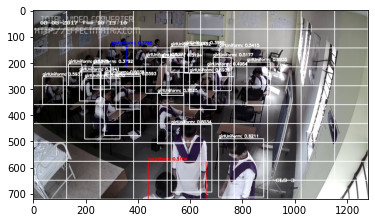

In [12]:
gridBoxes = computeGrid(1280, 720)
iouVals = calculateIOUs(width, height, gridBoxes, boxes)
print(iouVals)
grid_img = draw_grid(annotated_img, gridBoxes)
plt.imshow(cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB))

Number of detections before NMS:  3
Number of detections after NMS:  3


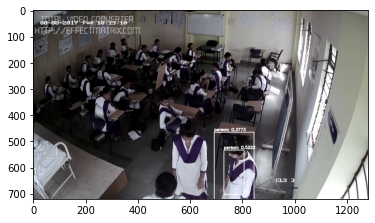

In [13]:
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 load images as BGR, convert it to RGB
height, width = img.shape[:2] 
blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
# r = blob[0, 0, :, :]
# plt.imshow()
person_net.setInput(blob)
#print("After setInput: ", net.dump())
outputs = person_net.forward(["yolo_16", "yolo_23"])
#print("output's shape: ", outputs.shape)
#print("After forward: ", net.dump())
boxes, confidences, classIDs = extract_boxes_confidences_classids_yolov3(outputs, confidenceThreshold, width, height)
print("Number of detections before NMS: ", len(boxes))
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidenceThreshold, person_nmsThreshold)
#print("Shape of idxs: ", idxs.shape)
print("Number of detections after NMS: ", len(idxs))
annotated_img = annotate_one(img, boxes, confidences, classIDs, idxs, person_labels, "person")
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))

# Prepare Dataset

In [29]:
dir_path = '/content/drive/MyDrive/classroom_analytics/experiment_2/labeled/'

In [15]:
uniform_weightsPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'tiny-yolo-uniform_40000.weights')
uniform_configPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'tiny-yolo-uniform.cfg')
uniform_labelsPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'uniform.names')
uniform_labels = open(uniform_labelsPath).read().strip().split('\n')

confidenceThreshold = 0.35
uniform_net = cv2.dnn.readNetFromDarknet(uniform_configPath, uniform_weightsPath)
gridBoxes = computeGrid(1280, 720)

videos = os.listdir(dir_path)
for video in videos:
  print("*** Processing ", video)
  hdf5_path = os.path.join(dir_path, video+'_data.hdf5')
  video_path = os.path.join(dir_path, video)
  image_addrs = glob.glob(os.path.join(video_path, "started", "*.jpg"))
  print("Num 'started' images = ", len(image_addrs))
  image_labels = len(image_addrs)*[1]
  not_started_image_addrs = glob.glob(os.path.join(video_path, "not_started", "*.jpg"))
  print("Num 'not_started' images = ", len(not_started_image_addrs))
  image_addrs.extend(not_started_image_addrs)
  image_labels.extend(len(not_started_image_addrs)*[0])
  assert(len(image_addrs) == len(image_labels))
  c = list(zip(image_addrs, image_labels))
  shuffle(c)
  (image_addrs, image_labels) = zip(*c)
  f = h5py.File(hdf5_path, mode='w')
  f.create_dataset("labels", (len(image_addrs),), np.uint8)
  f["labels"][...] = image_labels
  f.create_dataset("names", data = [os.path.basename(x) for x in image_addrs])
  f.create_dataset("images", (len(image_addrs), 145, 256, 3), np.uint8)
  img_uniform_features = []
  for i in range(len(image_addrs)):
    print ('Image: {}/{}'.format(i, len(image_addrs)) )
    addr = image_addrs[i]
    img = cv2.imread(addr)
    #print("Shape of this image is ", img.shape)
    assert(img.shape == (720, 1280, 3))
    small_img = cv2.resize(img, (256, 145), interpolation=cv2.INTER_CUBIC)
    #assert(small_img.shape == (145, 256, 3))
    small_img = cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB) # cv2 load images as BGR, convert it to RGB
    f["images"][i, ...] = small_img[None] 
    height, width = img.shape[:2] 
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    uniform_net.setInput(blob)
    output = uniform_net.forward("detection_out")
    boxes, confidences, classIDs = extract_boxes_confidences_classids_yolov2(output, confidenceThreshold, width, height)
    iouVals = calculateIOUs(width, height, gridBoxes, boxes)
    img_uniform_features.append(iouVals)
  feat = np.asarray(img_uniform_features, dtype=np.float)
  f.create_dataset("img_uniform_features", data=feat)
  f.close()

Streaming output truncated to the last 5000 lines.
Image: 109/277
Image: 110/277
Image: 111/277
Image: 112/277
Image: 113/277
Image: 114/277
Image: 115/277
Image: 116/277
Image: 117/277
Image: 118/277
Image: 119/277
Image: 120/277
Image: 121/277
Image: 122/277
Image: 123/277
Image: 124/277
Image: 125/277
Image: 126/277
Image: 127/277
Image: 128/277
Image: 129/277
Image: 130/277
Image: 131/277
Image: 132/277
Image: 133/277
Image: 134/277
Image: 135/277
Image: 136/277
Image: 137/277
Image: 138/277
Image: 139/277
Image: 140/277
Image: 141/277
Image: 142/277
Image: 143/277
Image: 144/277
Image: 145/277
Image: 146/277
Image: 147/277
Image: 148/277
Image: 149/277
Image: 150/277
Image: 151/277
Image: 152/277
Image: 153/277
Image: 154/277
Image: 155/277
Image: 156/277
Image: 157/277
Image: 158/277
Image: 159/277
Image: 160/277
Image: 161/277
Image: 162/277
Image: 163/277
Image: 164/277
Image: 165/277
Image: 166/277
Image: 167/277
Image: 168/277
Image: 169/277
Image: 170/277
Image: 171/277
Imag

# Dataset sanity check



In [9]:
hdf5files = glob.glob(os.path.join(dir_path, "*.hdf5"))
for hdf5file in hdf5files:
  print("Checking ", hdf5file)
  dir_name = os.path.splitext(os.path.basename(hdf5file))[0].split("_")[0]
  started_path = os.path.join(dir_path, dir_name, "started")
  not_started_path = os.path.join(dir_path, dir_name, "not_started")
  if os.path.isdir(started_path):
    num_started = len(os.listdir(started_path))
  else:
    num_started = 0
  if os.path.isdir(not_started_path):
    num_not_started = len(os.listdir(not_started_path))
  else:
    num_not_started = 0
  total = num_started + num_not_started
  dataset = h5py.File(hdf5file, "r")
  images = np.array(dataset["images"][:]) # train set images
  labels = np.array(dataset["labels"][:]) # train set labels
  img_uniform_features = np.array(dataset["img_uniform_features"][:])
  names = np.array(dataset["names"][:])
  assert(images.shape == (total, 145, 256, 3))
  assert(labels.shape == (total,))
  assert(img_uniform_features.shape == (total, 100))
  assert(names.shape == (total,))

Checking  /content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdalab-080817-1013_data.hdf5
Checking  /content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdalab-101117-1140_data.hdf5
Checking  /content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdalab-241117-1114_data.hdf5
Checking  /content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdalab-241117-1549_data.hdf5
Checking  /content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdatheory-041217-1107_data.hdf5
Checking  /content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdatheory-041217-1639_data.hdf5
Checking  /content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdatheory-071217-1638_data.hdf5
Checking  /content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdatheory-221117-1633_data.hdf5
Checking  /content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-itlab-061217-1646_data.hdf5

# Dataset Stats



{'apollo-gdalab': (599, 337), 'apollo-gdatheory': (430, 272), 'apollo-itlab': (693, 224), 'apollo-palab': (508, 576), 'apollo-patheory': (966, 102), 'ica-class1': (607, 593), 'ica-lab': (1105, 24), 'orion-class1': (254, 46)}


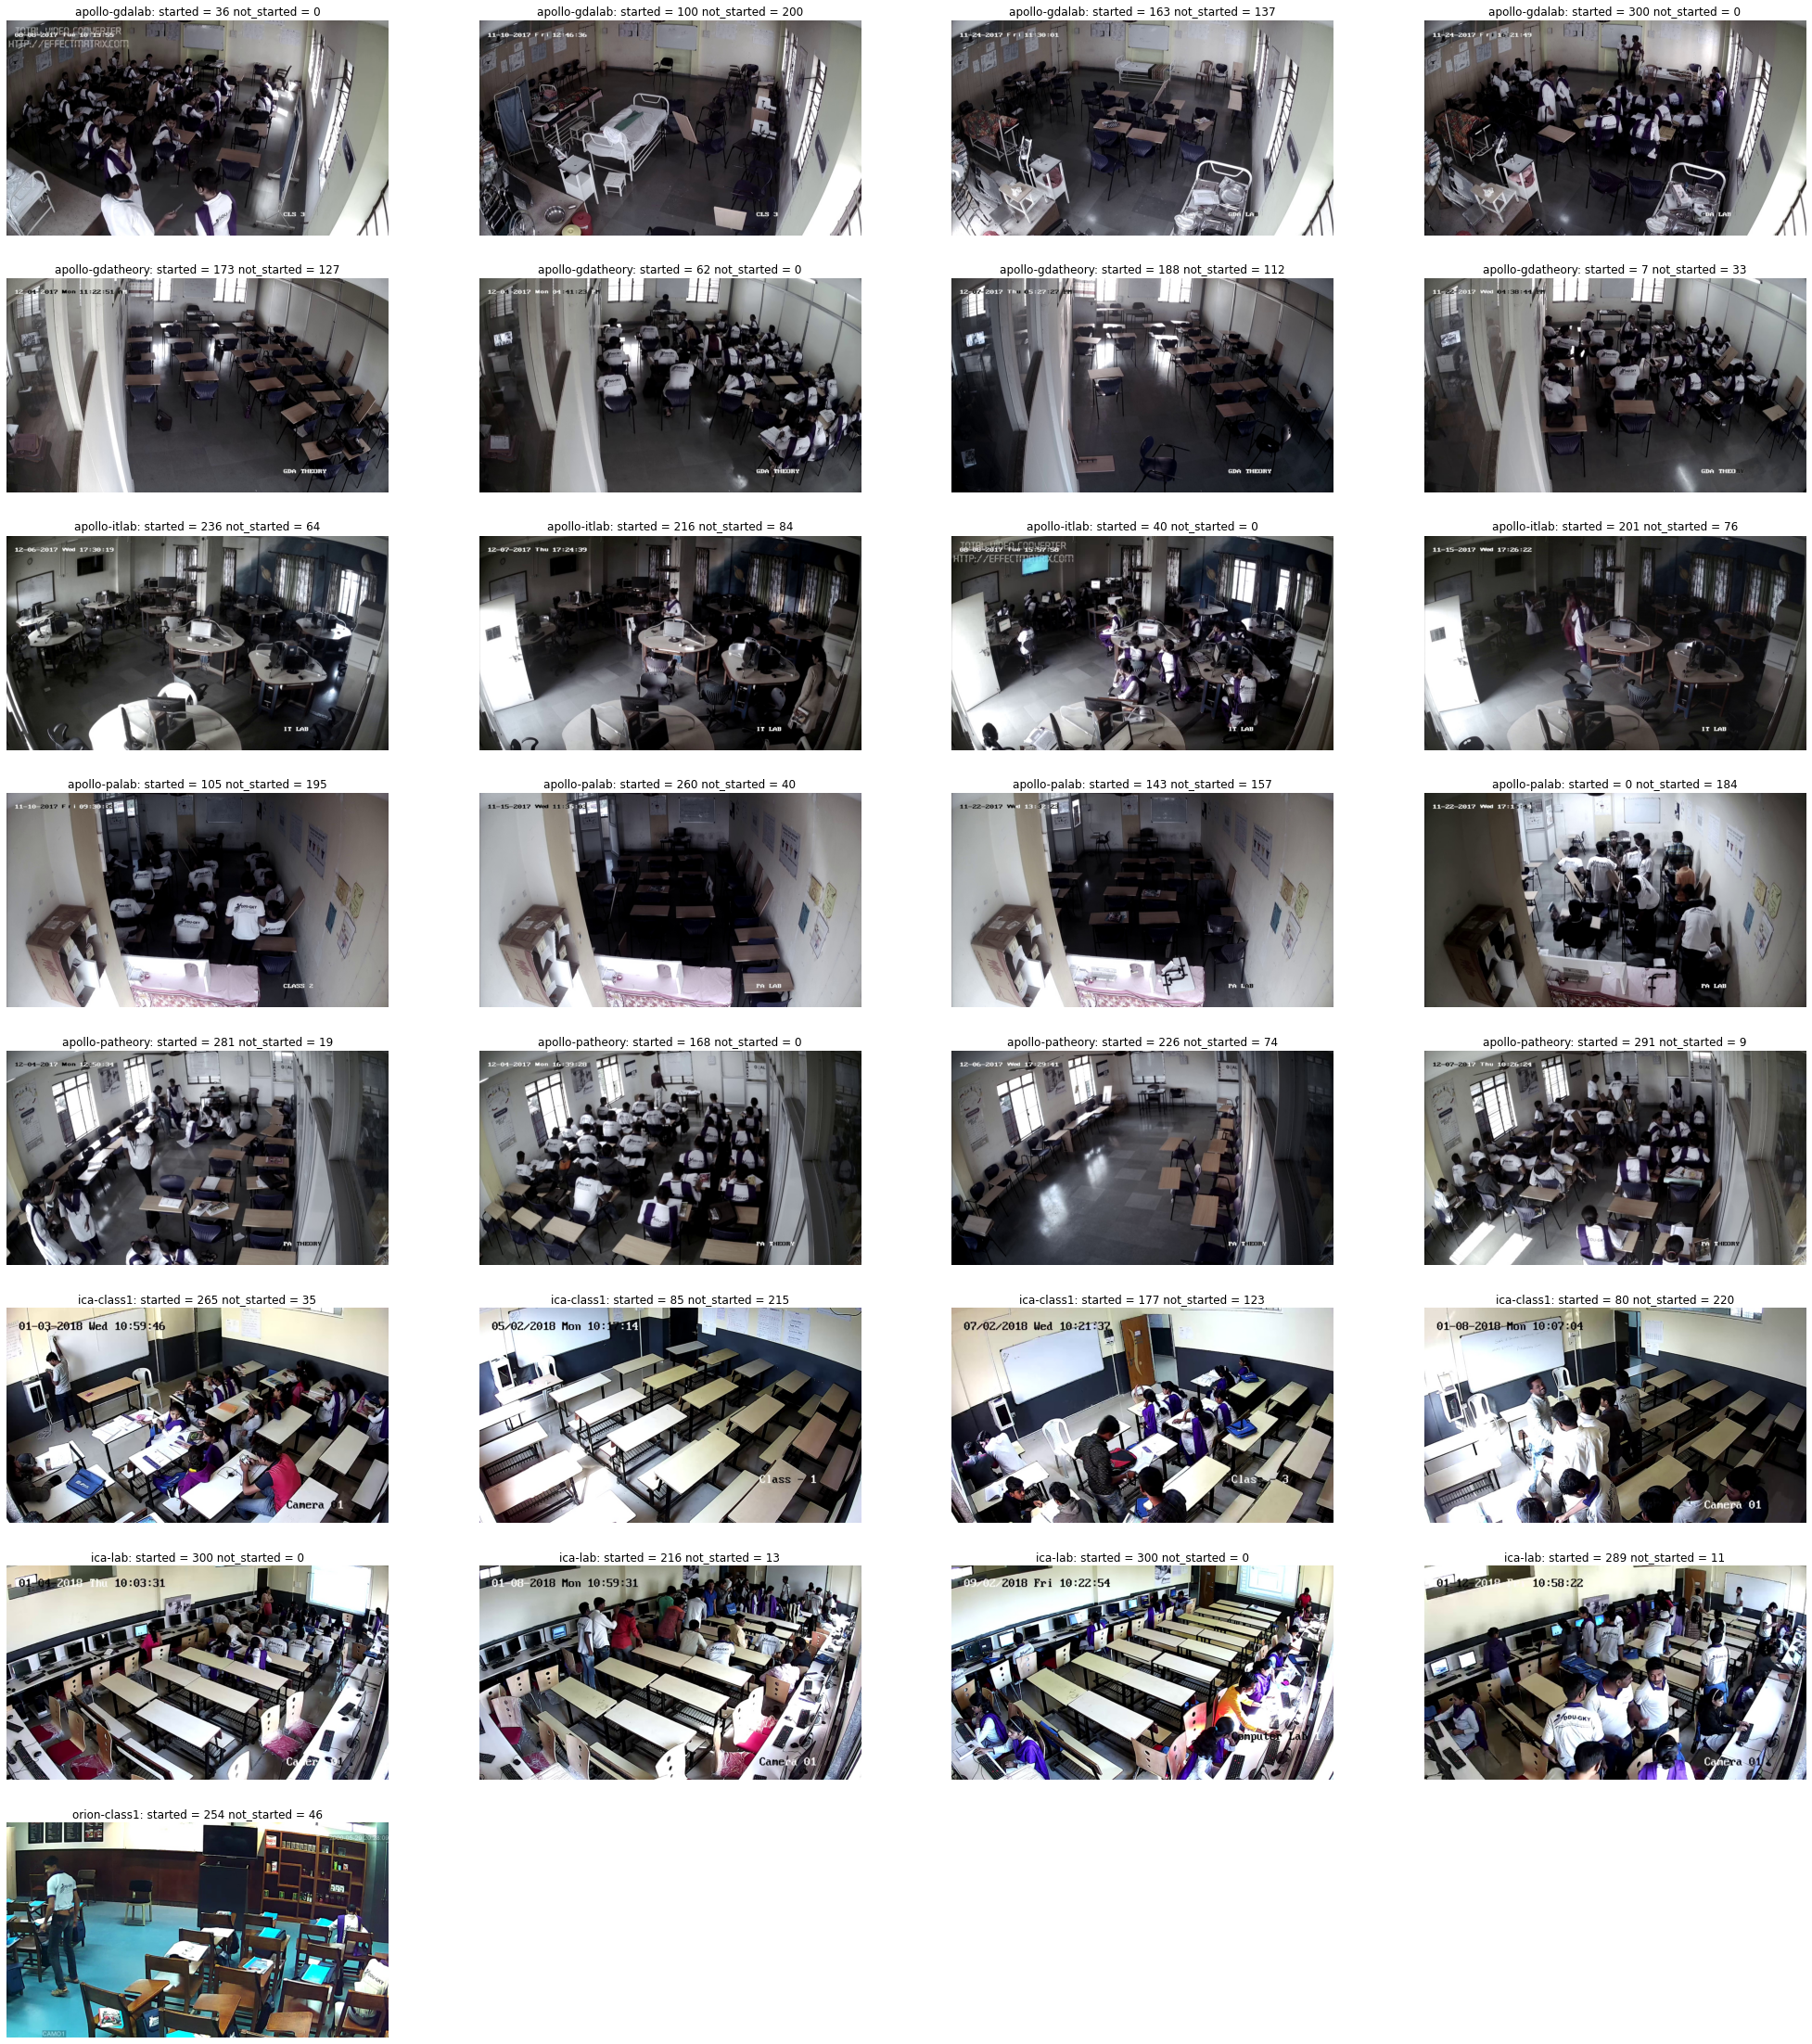

In [7]:
files = os.listdir(dir_path)
row = 0
index = 1
stats = {}
plt.figure(figsize = (35,40))
for file in files:
  file_path = os.path.join(dir_path, file)
  if not os.path.isdir(file_path):
    continue
  center_class = file.split('-')[0]+"-"+file.split('-')[1]
  started_path = os.path.join(file_path, "started")
  not_started_path = os.path.join(file_path, "not_started")
  if os.path.isdir(started_path):
    started_files = os.listdir(started_path)
    num_started = len(started_files)
    reference_img = cv2.imread(os.path.join(started_path, started_files[0]))
  else:
    num_started = 0
  if os.path.isdir(not_started_path):
    not_started_files = os.listdir(not_started_path)
    num_not_started = len(not_started_files)
    reference_img = cv2.imread(os.path.join(not_started_path, not_started_files[0]))
  else:
    num_not_started = 0
  if center_class not in stats:
    stats[center_class] = (num_started, num_not_started)
  else:
    stats[center_class] = (stats[center_class][0]+num_started, stats[center_class][1]+num_not_started)
  plt.subplot(8,4,row*4+index)
  plt.imshow(cv2.cvtColor(reference_img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(center_class + ': started = ' + str(num_started) + " not_started = " + str(num_not_started))
  index += 1
  if index == 5:
    row += 1
    index = 1
print(stats)

In [8]:
from tabulate import tabulate
table = []
header_row = ["class", "num_started", "num_not_started", "total"]
#table.append(header_row)
total_num_started = 0
total_num_not_started = 0
grand_total = 0
for center_class in stats:
  class_row = []
  class_row.append(center_class)
  num_started = stats[center_class][0]
  class_row.append(num_started)
  num_not_started = stats[center_class][1]
  class_row.append(num_not_started)
  class_row.append(num_started + num_not_started)
  table.append(class_row)
  total_num_started += num_started
  total_num_not_started += num_not_started
  grand_total += (num_started + num_not_started)
total_row = []
total_row.append("Total")
total_row.append(total_num_started)
total_row.append(total_num_not_started)
assert(grand_total == (total_num_started + total_num_not_started))
total_row.append(grand_total)
table.append(total_row)
print(tabulate(table,headers=header_row))

class               num_started    num_not_started    total
----------------  -------------  -----------------  -------
apollo-gdalab               599                337      936
apollo-gdatheory            430                272      702
apollo-itlab                693                224      917
apollo-palab                508                576     1084
apollo-patheory             966                102     1068
ica-class1                  607                593     1200
ica-lab                    1105                 24     1129
orion-class1                254                 46      300
Total                      5162               2174     7336


# Model 1: Logistic Regression with hand-crafted features

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score

## Train-test split at the level of class/center

In [19]:
results = []
results_header = ["test-class", "tn", "fp", "fn", "tp", "f1"]
splits = ['apollo-gdalab', 'apollo-gdatheory', 'apollo-itlab', 'apollo-palab', 'apollo-patheory', 'ica-class1', 'ica-lab', 'orion-class1']
#splits = ['apollo-gdalab']
for split in splits:
  row = [split]
  #print("\n*** Using ", split, " class videos as test and remaining as train")
  # create train and test appropriately
  #train_imgs = []
  train_features = []
  train_names = []
  train_labels = []
  #test_imgs = []
  test_features = []
  test_labels = []
  test_names = []
  hdf5files = glob.glob(os.path.join(dir_path, "*.hdf5"))
  for hdf5file in hdf5files:
    dataset = h5py.File(hdf5file, "r")
    if os.path.basename(hdf5file).startswith(split):
      # these should be in test
      #print("Adding ", hdf5file, " to test")
      # images = dataset["images"][:] # shape (N, a, b, c)
      # images = images.reshape(images.shape[0], -1)  # shape (N, aXbXc)
      # test_imgs.extend(images)
      features = dataset["img_uniform_features"][:] # shape (N, 100)
      test_features.extend(features)
      names = dataset["names"][:]
      test_names.extend(names)
      labels = dataset["labels"][:]
      test_labels.extend(labels)
    else:
      # these should be in train
      #print("Adding ", hdf5file, " to train")
      # images = dataset["images"][:]
      # images = images.reshape(images.shape[0], -1)
      # train_imgs.extend(images)
      features = dataset["img_uniform_features"][:]
      train_features.extend(features)
      names = dataset["names"][:]
      train_names.extend(names)
      labels = dataset["labels"][:]
      train_labels.extend(labels)
  train_X = np.array(train_features)
  #train_X = train_X/255.   # required when pixel values are used as features. Uniform features are already normalized
  #print("train_X's shape = ", train_X.shape)
  train_y = np.array(train_labels)
  #print("train_y's shape = ", train_y.shape)
  assert(train_X.shape[0] == train_y.shape[0])

  # #verify data
  # check_img = train_X[0]
  # print("check_image shape: ", check_img.shape)
  # check_img = check_img.reshape(145, 256, 3)
  # print("check_image shape: ", check_img.shape)
  # plt.imshow(check_img)
  # print("Label: ", train_y[0])
  # print("Name: ", train_names[0])
  # break
  
  logisticRegr = LogisticRegression(class_weight='balanced', max_iter=250)   #l2 regularization, 
  logisticRegr.fit(train_X, train_y)
  test_X = np.array(test_features)
  #test_X = test_X/255.
  #print("test_X's shape = ", test_X.shape)
  test_y = np.array(test_labels)
  assert(test_X.shape[0] == test_y.shape[0])
  #print("test_y's shape = ", test_y.shape)
  assert(train_X.shape[1]==test_X.shape[1])
  predictions = logisticRegr.predict(test_X)
  assert(predictions.shape == (test_X.shape[0],))
  tn, fp, fn, tp = (metrics.confusion_matrix(test_y, predictions)).ravel()
  f1 = f1_score(test_y, predictions)
  row.append(tn)
  row.append(fp)
  row.append(fn)
  row.append(tp)
  row.append(f1)
  results.append(row)
print(tabulate(results, headers=results_header))

test-class          tn    fp    fn    tp        f1
----------------  ----  ----  ----  ----  --------
apollo-gdalab      264    73   166   433  0.78371
apollo-gdatheory   190    82    14   416  0.896552
apollo-itlab       183    41   473   220  0.461216
apollo-palab       349   227   188   320  0.606635
apollo-patheory     61    41    13   953  0.972449
ica-class1         535    58   264   343  0.680556
ica-lab             17     7   908   197  0.300993
orion-class1        44     2   232    22  0.158273


## Train-test split at the level of sessions/days

In [21]:
# create train and test appropriately
train_features = []
train_names = []
train_labels = []
test_features = []
test_labels = []
test_names = []
hdf5files = glob.glob(os.path.join(dir_path, "*.hdf5"))
taken_in_test = {'apollo-gdalab': False, 'apollo-gdatheory': False, 'apollo-itlab': False, 'apollo-palab': False, 'apollo-patheory': False, 'ica-class1': False, 'ica-lab': False, 'orion-class1': True}
for hdf5file in hdf5files:
  dataset = h5py.File(hdf5file, "r")
  if taken_in_test[(os.path.basename(hdf5file)).split("-")[0]+"-"+(os.path.basename(hdf5file)).split("-")[1]]:
    # these should be in train
    print("Adding ", hdf5file, " in train" )
    features = dataset["img_uniform_features"][:]
    train_features.extend(features)
    names = dataset["names"][:]
    train_names.extend(names)
    labels = dataset["labels"][:]
    train_labels.extend(labels)
  else:
    # these should be in test
    print("Adding ", hdf5file, " in test")
    features = dataset["img_uniform_features"][:] # shape (N, 100)
    test_features.extend(features)
    names = dataset["names"][:]
    test_names.extend(names)
    labels = dataset["labels"][:]
    test_labels.extend(labels)
    taken_in_test[(os.path.basename(hdf5file)).split("-")[0]+"-"+(os.path.basename(hdf5file)).split("-")[1]] = True
train_X = np.array(train_features)
#train_X = train_X/255.   # required when pixel values are used as features. Uniform features are already normalized
print("train_X's shape = ", train_X.shape)
train_y = np.array(train_labels)
print("train_y's shape = ", train_y.shape)
assert(train_X.shape[0] == train_y.shape[0])

logisticRegr = LogisticRegression(class_weight='balanced', max_iter=250)   #l2 regularization, 
logisticRegr.fit(train_X, train_y)
test_X = np.array(test_features)
#test_X = test_X/255.
print("test_X's shape = ", test_X.shape)
test_y = np.array(test_labels)
assert(test_X.shape[0] == test_y.shape[0])
print("test_y's shape = ", test_y.shape)
assert(train_X.shape[1]==test_X.shape[1])
predictions = logisticRegr.predict(test_X)
assert(predictions.shape == (test_X.shape[0],))
tn, fp, fn, tp = (metrics.confusion_matrix(test_y, predictions)).ravel()
f1 = f1_score(test_y, predictions)
print(f"TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}, F1 = {f1}")

train_X's shape =  (5500, 100)
train_y's shape =  (5500,)
test_X's shape =  (1836, 100)
test_y's shape =  (1836,)
TN = 253, FP = 187, FN = 499, TP = 897, F1 = 0.7233870967741935


## Final model trained on full data

In [30]:
train_features = []
train_names = []
train_labels = []
hdf5files = glob.glob(os.path.join(dir_path, "*.hdf5"))
for hdf5file in hdf5files:
  dataset = h5py.File(hdf5file, "r")
  features = dataset["img_uniform_features"][:]
  train_features.extend(features)
  names = dataset["names"][:]
  train_names.extend(names)
  labels = dataset["labels"][:]
  train_labels.extend(labels)
train_X = np.array(train_features)
#train_X = train_X/255.   # required when pixel values are used as features. Uniform features are already normalized
print("train_X's shape = ", train_X.shape)
train_y = np.array(train_labels)
print("train_y's shape = ", train_y.shape)
assert(train_X.shape[0] == train_y.shape[0])

logisticRegr = LogisticRegression(class_weight='balanced', max_iter=250)   #l2 regularization, 
logisticRegr.fit(train_X, train_y)
model_file = 'logistic_regression_model.sav'
model_file_path = os.path.join('/content/drive/MyDrive/classroom_analytics', model_file)
pickle.dump(logisticRegr, open(model_file_path, 'wb'))
print("Model file saved!")

train_X's shape =  (7336, 100)
train_y's shape =  (7336,)
Model file saved!


## Inference from saved model

Prediction: started


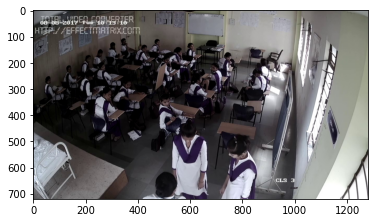

In [8]:
uniform_weightsPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'tiny-yolo-uniform_40000.weights')
uniform_configPath = os.path.join('/content/drive/MyDrive/classroom_analytics/', 'tiny-yolo-uniform.cfg')
confidenceThreshold = 0.35
uniform_net = cv2.dnn.readNetFromDarknet(uniform_configPath, uniform_weightsPath)
gridBoxes = computeGrid(1280, 720)
classes = np.array(["not_started", "started"])
model_file = 'logistic_regression_model.sav'
model_file_path = os.path.join('/content/drive/MyDrive/classroom_analytics', model_file)
lr_model = pickle.load(open(model_file_path, 'rb'))
test_img = cv2.imread(os.path.join('/content/drive/MyDrive/classroom_analytics/experiment_2/labeled/apollo-gdalab-080817-1013/started', 'apollo-gdalab-080817-1013_125.jpg'))
assert(test_img.shape == (720, 1280, 3))
height, width = test_img.shape[:2] 
blob = cv2.dnn.blobFromImage(test_img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
uniform_net.setInput(blob)
output = uniform_net.forward("detection_out")
boxes, confidences, classIDs = extract_boxes_confidences_classids_yolov2(output, confidenceThreshold, width, height)
features = calculateIOUs(width, height, gridBoxes, boxes)
test_X = np.array(features)
test_X = test_X.reshape((1,100))
prediction = lr_model.predict(test_X)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
print("Prediction: " + classes[prediction[0]])
